# Analyse exploratoire

Analysons le fichier cree dans le notebook concernant le nettoyage afin d'essayer dans un prmier temps de combler de facon ausssi appropriee que possible les valeurs manquantes. Puis de preparer ce qu'il faut pour l'appli souhaitee.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
df=pd.read_csv("C:/Users/leila/venduenfr.csv",sep=',',low_memory=False)

In [3]:
main_list=['code','energy_100g','sugars_100g','saturated-fat_100g','fiber_100g','proteins_100g','sodium_100g', 
'fruits-vegetables-nuts_100g','alcohol_100g','pnns_groups_2','categorie','nutrition-score-fr_100g','nutriscore_grade']

Creation de trois dataframes suivant la categorie boissons, cakes, snacks

In [4]:
snacks=df[df['categorie']=='snacks'].copy()
cakes=df[df['categorie']=='cakes'].copy()
boissons=df[df['categorie']=='boissons'].copy()

for nom in ['snacks','cakes','boissons'] :
    print(nom+' ',df[(df['categorie']==nom)].shape)


snacks  (29332, 37)
cakes  (56641, 37)
boissons  (42744, 37)


### Etude des boissons


L'objectif de cette etude est de trouver une methode appropriee pour remplacer les valeurs manquantes dans les nutriments et l'energie. Remplacer les valeurs manquantes par 0 biaise tous les calculs et induirait des reponses inappropriees pour l'appli.

Dans boissons on va retitrer tout ce qui concerne les eaux puisqu'elles sont toutes de nutrigrade 'A' et bonnes pour la sante quelque soit la pathologie. L'objectif de l'appli n'est pas de dire au lieu d'un jus de fruit prenez de l'eau, mais de proposer dans la gamme de produits souhaites le moins mauvais. 

In [5]:
print(boissons['pnns_groups_2'].unique())
#on retire les eaux
boissons=boissons[boissons['pnns_groups_2']!='waters and flavored waters']
boissons.shape

['sweetened beverages' 'fruit juices' 'unsweetened beverages' 'unknown'
 'alcoholic beverages' 'teas and herbal teas and coffees'
 'artificially sweetened beverages' 'waters and flavored waters'
 'fruit nectars']


(41295, 37)

In [6]:
boissons[main_list].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41295 entries, 57 to 788902
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   code                         41295 non-null  object 
 1   energy_100g                  27261 non-null  float64
 2   sugars_100g                  27152 non-null  float64
 3   saturated-fat_100g           27120 non-null  float64
 4   fiber_100g                   10294 non-null  float64
 5   proteins_100g                26865 non-null  float64
 6   sodium_100g                  26479 non-null  float64
 7   fruits-vegetables-nuts_100g  1922 non-null   float64
 8   alcohol_100g                 4814 non-null   float64
 9   pnns_groups_2                41295 non-null  object 
 10  categorie                    41295 non-null  object 
 11  nutrition-score-fr_100g      20760 non-null  float64
 12  nutriscore_grade             20760 non-null  object 
dtypes: float64(9),

Ayant remarque que certaines boissons contenant de l'alcool ne sont pas dans le groupe 'alcoholic beverages', nous allons modifier cela, semblant plus logique.

In [7]:
print('nombre initial de boissons alcoolisees : ',len(boissons[boissons['pnns_groups_2']=='alcoholic beverages']))

#des qu'une boisson contient de l'alcool on la classe dans le groupe des boissons alcoolisees
lc=boissons[boissons['alcohol_100g']>0]['code'].values
boissons.loc[boissons['code'].isin(lc),'pnns_groups_2']='alcoholic beverages'

print('nombre de boissons alcoolisees : ',len(boissons[boissons['pnns_groups_2']=='alcoholic beverages']))

nombre initial de boissons alcoolisees :  10788
nombre de boissons alcoolisees :  10830


#### Etudes de la distribution des nutriments 

On cherche quelle est la forme des distributions, en particulier quelle est la modalite. Pour toute distributions multimodale, il n'est pas coherent de remplacer les valeurs manquantes par la moyenne ou la mediane. 

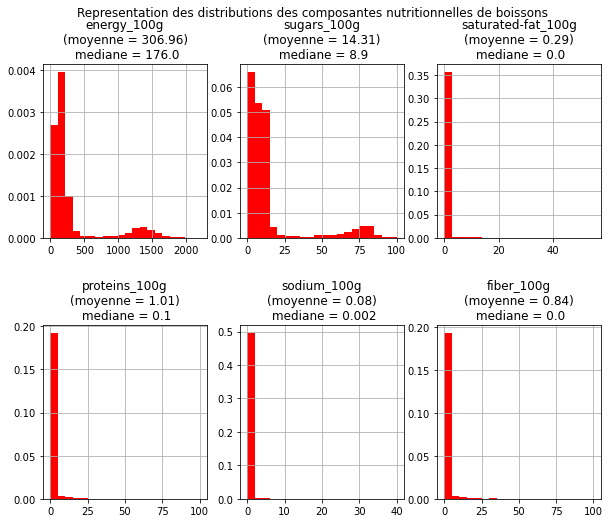

In [8]:
l=['energy_100g','sugars_100g','saturated-fat_100g','proteins_100g','sodium_100g','fiber_100g']

ngraphe=len(l)
ncols=3
nrows=ngraphe//ncols

plt.figure(figsize=(10,8))
plt.suptitle("Representation des distributions des composantes nutritionnelles de {}".format(nom) )
plt.gcf().subplots_adjust(hspace=0.5)

for k in range(len(l)) :
    plt.subplot(nrows,ncols,k+1)
    boissons[l[k]].hist(density=True,bins=20,color='r')
    plt.title(l[k]+'\n(moyenne = {})\n mediane = {}'.format(np.round(boissons[l[k]].mean(),2),
                                                            np.round(boissons[l[k]].median(),3)))
    
plt.show()  


D'apres les graphiques precedents :  
- les distributions des acides gras satures, des proteins et du sodium sont unimodales 
- la distribution du sucre et celle de l'energie sont  bimodales 

On va regarder par categorie de boissons comment se comporte la distribution des nutriments par rapport a une loi normale.   
Cela permettra en particulier de savoir si la distribution du sucre et de l'energie est modifiee suivant la categorie


In [9]:
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

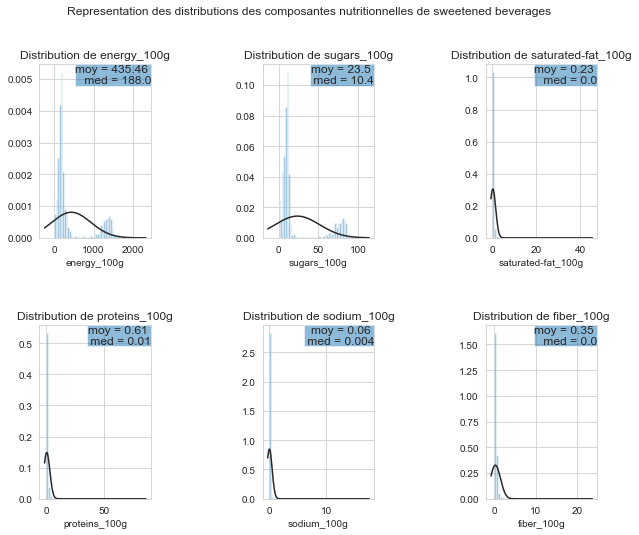

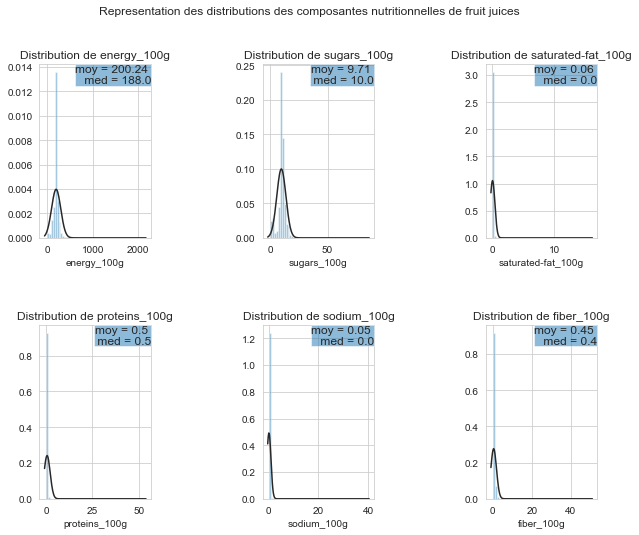

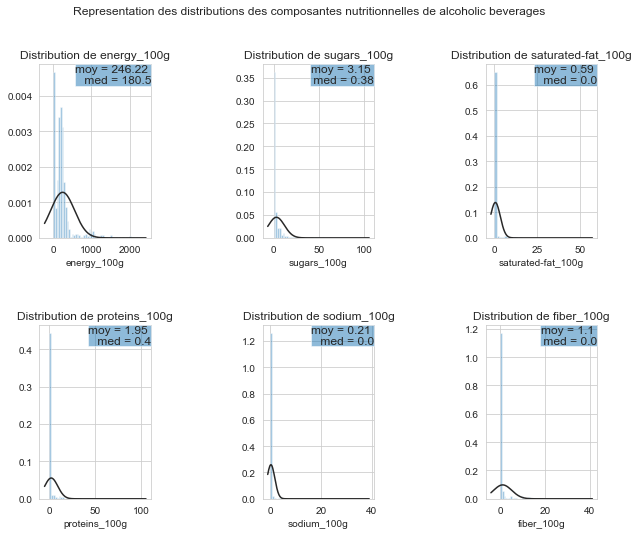

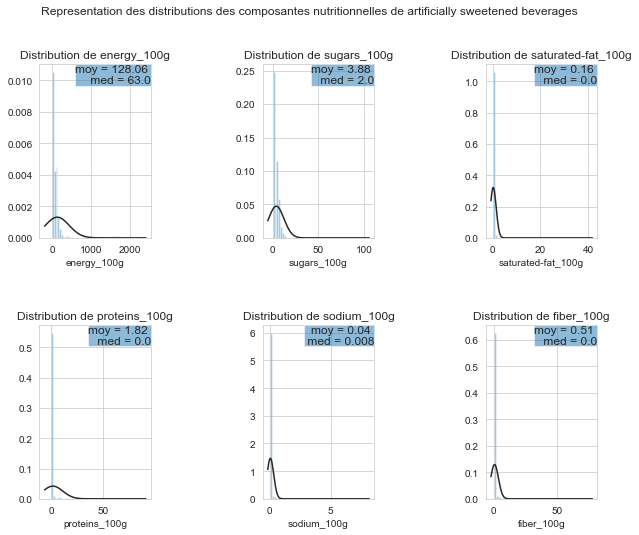

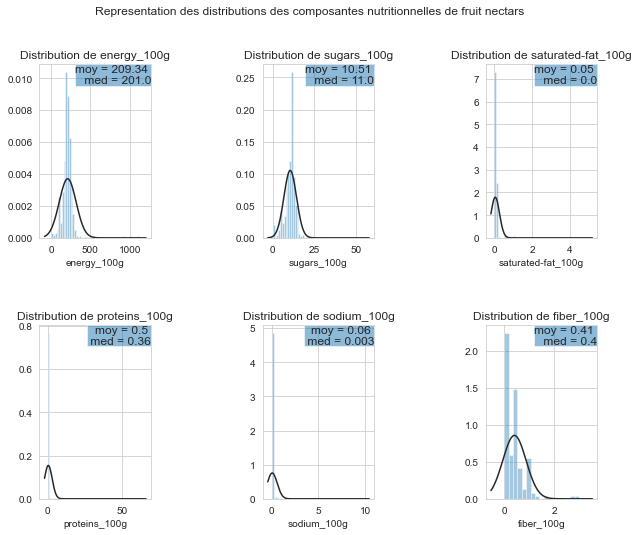

In [10]:
def representer(l,data,cat):
    '''Represente les distributions des colonnes de data dont le nom est dans l 
    Args : l= liste des colonnes numeriques, data =base de donnees, nom = string 
    Return : distribution des elements de l suivant la categorie cat vs loi normale'''
    
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(10,8))
    plt.suptitle("Representation des distributions des composantes nutritionnelles de {}".format(cat))
    plt.gcf().subplots_adjust(hspace=0.5,wspace=1)

    sub = 0
    for k in range(len(l)):
        fig.add_subplot(2,3,k+1)
    
        left, width=0, 1
        bottom, height=0, 1
        right=left + width
        top=bottom + height
    
        col=l[k]
        ax = sns.distplot(data[col], fit=stats.norm, kde=False)
        ax.set_title('Distribution de {}'.format(l[k]))
        ax.text(right, top, 'moy = {} \n med = {}'.format(np.round(data[l[k]].mean(),2),np.round(data[l[k]].median(),3)),
            horizontalalignment='right',verticalalignment='top',transform=ax.transAxes, fontsize = 12,
                bbox={'alpha':0.5, 'pad':0}) 
        sub += 1
    plt.show()

for name in ['sweetened beverages','fruit juices','alcoholic beverages','artificially sweetened beverages','fruit nectars']:
    representer(l,boissons[boissons['pnns_groups_2']==name][l],name)

Aucune des distributions n'est une loi normale puisque l'on a majoritairement un ecart significatif entre moyenne et mediane.
Il est donc inutile d'utiliser un test de conformite tel que celui de Kolmogorov-Smirnov.

L'energie sera traitee ulterieurement car elle depend en particulier du sucre et des proteines.  
Pour le sucre, les acides gras satures et le sel qui sont des sujets preoccupants pour les pathologies etudiees, il semble raisonnable de prendre le max entre la moyenne et la mediane excepte pour le sucre de la categorie 'sweetened beverages'.
Pour les proteines et les fibres qui sont des donnees positives pour la sante, il est plus prudent de prendre le min entre la moyenne et la mediane excepte pour les fibres dans le cas des nectars.

Nous allons donc etudier les cas particuliers

#### Etude des boissons sucrees et des nectars

In [11]:
swb=boissons[boissons['pnns_groups_2']=='sweetened beverages'].copy()
print(list(swb[swb['sugars_100g']>40.]['main_category_fr'].unique()))

['sodas', 'boissons lyophilisees', 'boissons avec sucre ajoute', 'limonades', 'boissons', 'thes glaces saveur citron', 'boissons sans sucre ajoute', 'sirops de menthe', 'boissons-au-citron', 'sirops de citron', 'sirops de peche', 'sirops de cerise', 'sodas au cola', 'sirops de fraise', 'sirops de myrtille', 'sirops de grenadine', 'en:supplement', 'sirops de citron vert', 'sirops de cassis', 'thes glaces', 'sirops de kiwi', 'sirops mojito', 'sirops de framboise', 'sirops aromatises', 'sirops-traditionnels', 'cappuccino', "sirops d'orange", "sirops a l'anis", 'sirops de pomme', 'sirops de pamplemousse', 'sirops-de-lavande', 'sirops de violette', 'sirops-de-caramel', 'sirops de pasteque', 'sirops de rose', 'sirops-de-goyave', 'sirops-ar', 'sirops-au-sucre-de-canne', "sirops d'orgeat", 'touraine noble joue', 'sirops-de-raspberry', 'sirops de chataignes', 'sirops aux fruits', 'sirops cola', 'boissons-concentrees', 'sirop-de-gingembre', 'sirop-de-melon', 'sirops de mangue', 'digestif', 'prep

On retrouve principalement des sirops, des sodas, des thes, boissons diverses et autres choses que des boissons. On va creer une colonne etiquette qui va classer les produits suivant les categories pre-citees

In [12]:
swb['etiquette']=swb['main_category_fr']
swb['etiquette']=swb['etiquette'].apply(lambda x : 'sirops' if 'sirop' in str(x) 
                                    else ('sodas' if ('soda' or 'limonade') in str(x) 
                                   else ('thes' if 'thes' in str(x) 
                                         else ('boissons' if 'boisson' in str(x) 
                                               else 'autres'))))

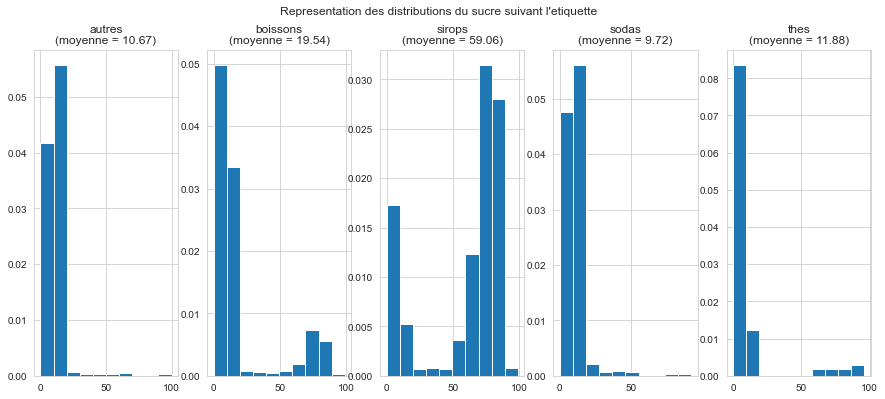

In [13]:
etiq=['autres', 'boissons', 'sirops', 'sodas', 'thes']
plt.figure(figsize=(15,6))
plt.suptitle("Representation des distributions du sucre suivant l'etiquette\n" )
plt.gcf().subplots_adjust(hspace=0.5)

for k in range(len(etiq)) :
    plt.subplot(1,5,k+1)
    swb[swb['etiquette']==etiq[k]]['sugars_100g'].hist(density=True,bins=10)
    plt.title(etiq[k]+'\n(moyenne = {})'.format(np.round(swb[swb['etiquette']==etiq[k]]['sugars_100g'].mean(),2)))
    
plt.show()  

<AxesSubplot:title={'center':'sugars_100g'}, xlabel='etiquette'>

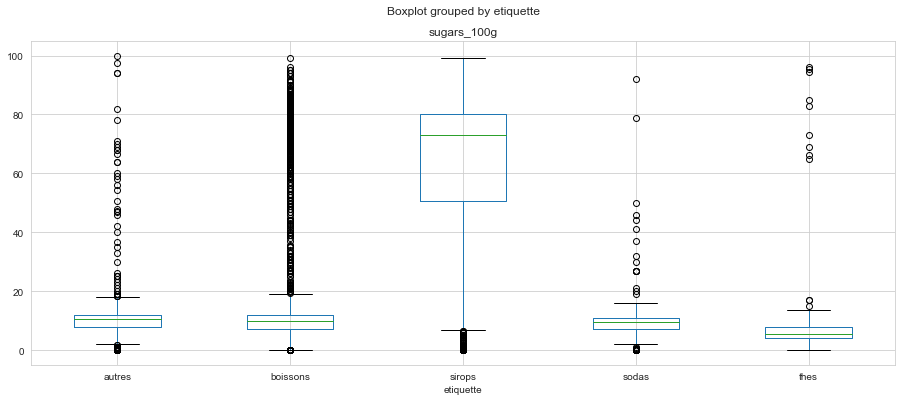

In [14]:
swb.boxplot('sugars_100g', by='etiquette', figsize=(15, 6))

En ayant regarde les outliers dans boissons, sirops et sodas, la quantité de sucre donnee est soit erronee (car n'est pas celle  pour 100ml) soit absente. On va donc mettre une valeur manquante. 
On peut alors remplacer les valeurs manquantes par la mediane suivant les etiquettes

<AxesSubplot:>

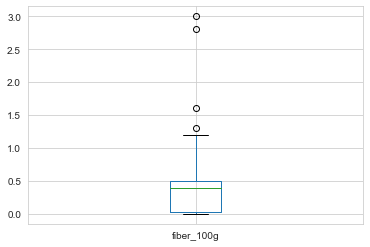

In [15]:
nectars=boissons[boissons['pnns_groups_2']=='fruit nectars'].copy()
nectars.boxplot('fiber_100g')


On met les outliers en valeurs manquantes et on remplace par la moyenne

In [16]:
#traitement des outliers
swb.loc[((swb['etiquette']=='sodas')&(swb['sugars_100g']>20.)),'sugars_100g']=np.nan
swb.loc[((swb['etiquette']=='sirops')&(swb['sugars_100g']<10.)),'sugars_100g']=np.nan
swb.loc[((swb['etiquette']=='boissons')&(swb['sugars_100g']>20.)),'sugars_100g']=np.nan
nectars.loc[nectars['fiber_100g']>1.2,'fiber_100g']=np.nan


Puisque l'on a mis des valeurs manquantes pour le sucre, il faut mettre des valeurs manquantes au même endroit pour l'energie,le nutriscore et le nutrigrade en raison de leur dependance avec le sucre et les fibres

In [17]:
codes_na=swb[swb['sugars_100g'].isna()]['code'].values
coden_na=nectars[nectars['fiber_100g'].isna()]['code'].values
code_na=np.concatenate([codes_na,coden_na])
for nom in ['energy_100g','nutrition-score-fr_100g','nutriscore_grade'] :
    swb.loc[swb['code'].isin(code_na),nom]=np.nan


In [18]:
boissons['etiquette']=boissons['pnns_groups_2']
boissons.loc[boissons['pnns_groups_2']=='sweetened beverages','etiquette']=swb['etiquette']

#mise a jours des outliers pour boissons
boissons.loc[boissons['code'].isin(codes_na),'sugars_100g']=np.nan
boissons.loc[boissons['code'].isin(coden_na),'fiber_100g']=np.nan
for nom in ['energy_100g','nutrition-score-fr_100g','nutriscore_grade'] :
    boissons.loc[boissons['code'].isin(code_na),nom]=np.nan

#remplacement des valeurs manquantes

for cat in ['fruit juices','alcoholic beverages','artificially sweetened beverages','fruit nectars','sweetened beverages']:
    for nutri in ['sugars_100g','saturated-fat_100g','sodium_100g','proteins_100g','fiber_100g'] :
        if (nutri=='sugars_100g' and cat=='sweetened beverages') :
            for nom in ['boissons', 'sodas','sirops'] :
                test=boissons[boissons['etiquette']==nom].copy()
                test[nutri].fillna(test[nutri].median(),inplace=True)
                boissons.loc[boissons['etiquette']==nom,nutri]=test[nutri] 
            
        elif nutri=='fiber_100g':
            test2=boissons[boissons['pnns_groups_2']==cat].copy()
            test2[nutri].fillna(min(test2[nutri].mean(),test2[nutri].median()),inplace=True)
            boissons.loc[boissons['pnns_groups_2']==cat,nutri]=test2[nutri]
        
        elif nutri=='proteins_100g':
            testp=boissons[boissons['pnns_groups_2']==cat].copy()
            testp[nutri].fillna(min(testp[nutri].mean(),testp[nutri].median()),inplace=True)
            boissons.loc[boissons['pnns_groups_2']==cat,nutri]=testp[nutri]
            
        else :
            test3=boissons[boissons['pnns_groups_2']==cat].copy()
            test3[nutri].fillna(max(test3[nutri].mean(),test3[nutri].median()),inplace=True)
            boissons.loc[boissons['pnns_groups_2']==cat,nutri]=test3[nutri]

boissons[main_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41295 entries, 57 to 788902
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   code                         41295 non-null  object 
 1   energy_100g                  25434 non-null  float64
 2   sugars_100g                  37864 non-null  float64
 3   saturated-fat_100g           37881 non-null  float64
 4   fiber_100g                   32380 non-null  float64
 5   proteins_100g                37903 non-null  float64
 6   sodium_100g                  37483 non-null  float64
 7   fruits-vegetables-nuts_100g  1922 non-null   float64
 8   alcohol_100g                 4814 non-null   float64
 9   pnns_groups_2                41295 non-null  object 
 10  categorie                    41295 non-null  object 
 11  nutrition-score-fr_100g      19687 non-null  float64
 12  nutriscore_grade             19687 non-null  object 
dtypes: float64(9),

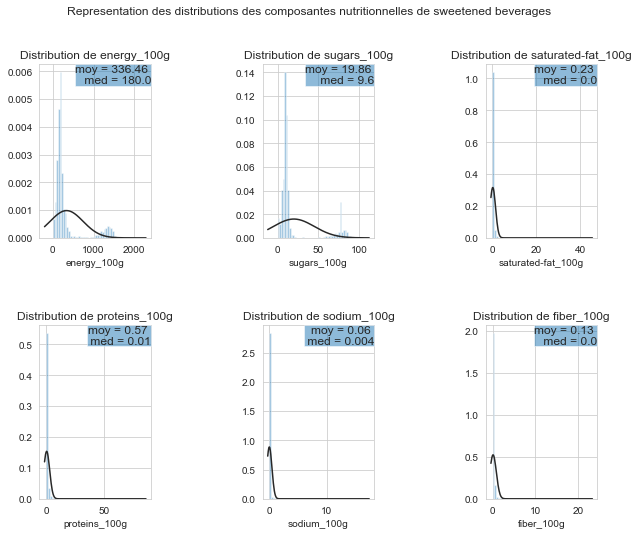

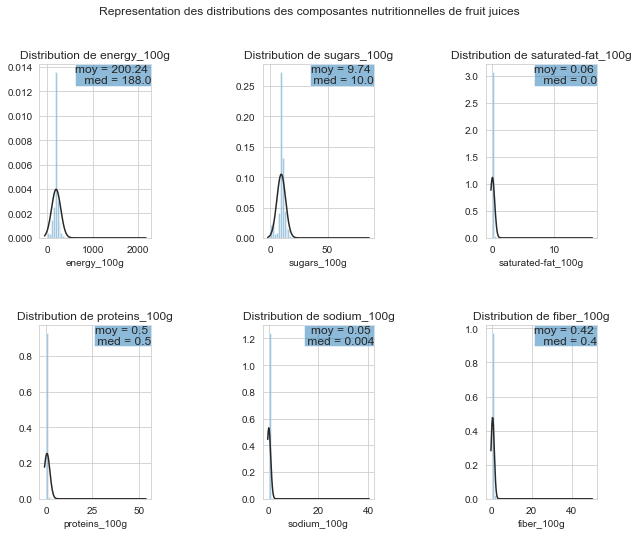

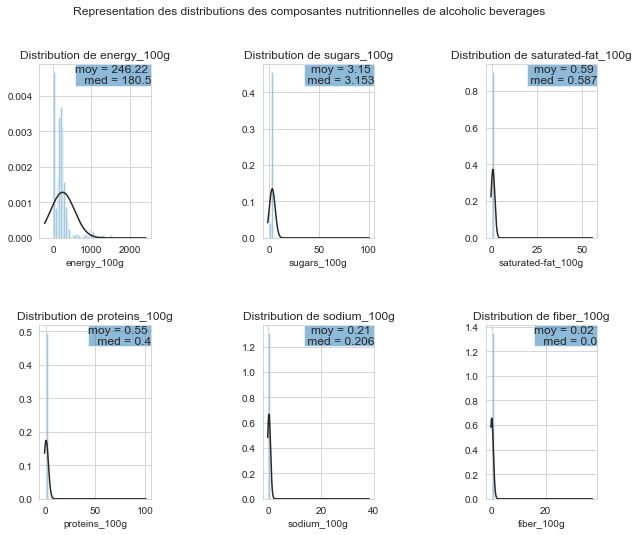

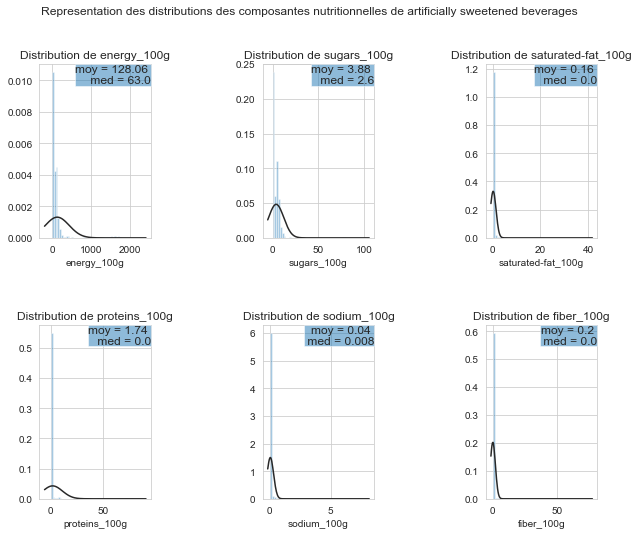

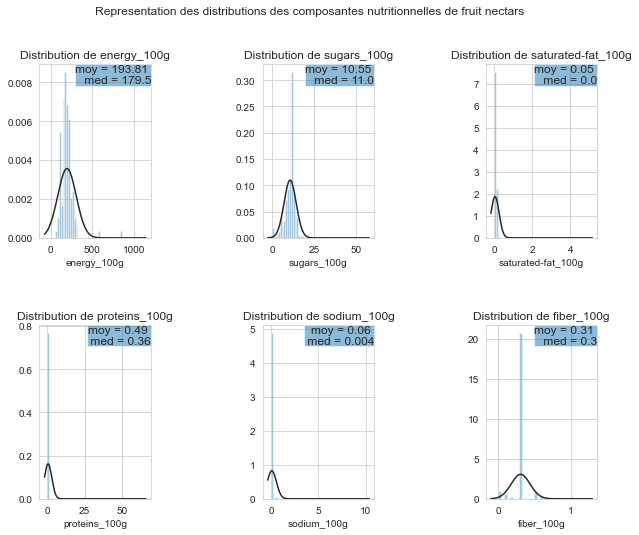

In [19]:
for name in ['sweetened beverages','fruit juices','alcoholic beverages','artificially sweetened beverages','fruit nectars']:
    representer(l,boissons[boissons['pnns_groups_2']==name][l],name)

Les remplacements ne semblent pas incoherents, les distributions restent similaires.


On s'interesse maintenant aux fruits-legumes_noix

<AxesSubplot:title={'center':'fruits-vegetables-nuts_100g'}, xlabel='etiquette'>

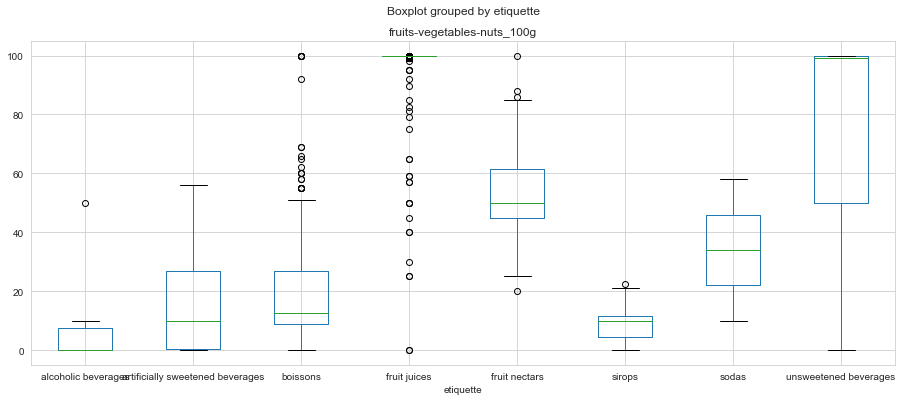

In [20]:
fln=boissons[boissons['etiquette'].isin(['unsweetened beverages', 'boissons', 'fruit juices','sirops',
       'artificially sweetened beverages', 'fruit nectars', 'sodas', 'alcoholic beverages'])].copy()
fln.boxplot('fruits-vegetables-nuts_100g', by='etiquette', figsize=(15, 6))


on utilise le min entre la moyenne et la mediane pour remplacer les valeurs manquantes des fln comme pour les proteins et les fibres

In [21]:
for etiq in ['fruit juices','alcoholic beverages','artificially sweetened beverages','fruit nectars','boissons','sirops',
             'sodas ']:
    t=boissons[boissons['etiquette']==etiq].copy()
    t['fruits-vegetables-nuts_100g'].fillna(min(t['fruits-vegetables-nuts_100g'].mean(),
                                                t['fruits-vegetables-nuts_100g'].median()),inplace=True)
    boissons.loc[boissons['etiquette']==etiq,'fruits-vegetables-nuts_100g']=t['fruits-vegetables-nuts_100g']



On veut maintenant completer les valeurs de l'energie. On commence par regarder si l'energie est liee a un seul des nutriments parmi le sucre, les acides gras satures, les proteins et le sodium

In [22]:
l=['sugars_100g','saturated-fat_100g','proteins_100g','sodium_100g','fiber_100g']
select_boisson=boissons[((boissons['etiquette'].isin(['fruit juices','alcoholic beverages','artificially sweetened beverages',
                                                      'fruit nectars','boissons','sirops','sodas ']))&(boissons['energy_100g'].notna()))].copy()
sbe=select_boisson[['sugars_100g','saturated-fat_100g','proteins_100g','sodium_100g','fiber_100g','energy_100g','etiquette']]
sbe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14148 entries, 102 to 788577
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sugars_100g         14148 non-null  float64
 1   saturated-fat_100g  14148 non-null  float64
 2   proteins_100g       14148 non-null  float64
 3   sodium_100g         14148 non-null  float64
 4   fiber_100g          14148 non-null  float64
 5   energy_100g         14148 non-null  float64
 6   etiquette           14148 non-null  object 
dtypes: float64(6), object(1)
memory usage: 884.2+ KB


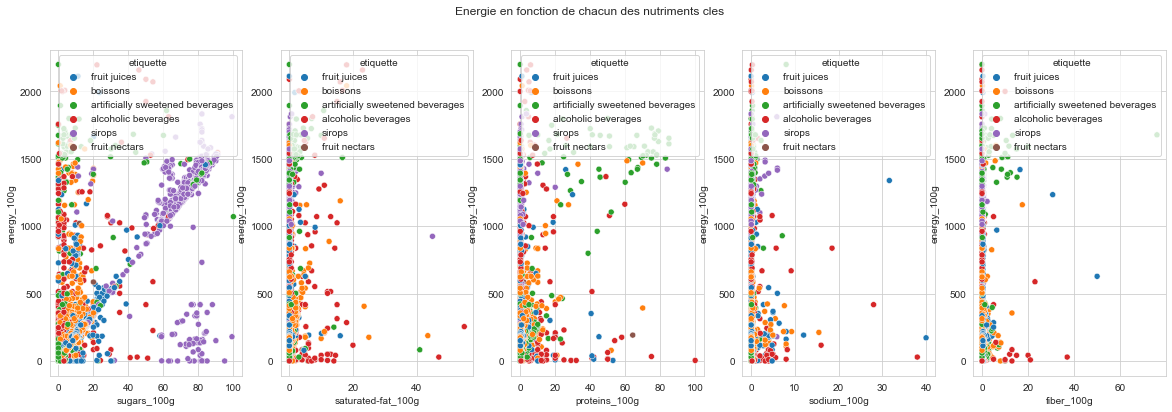

In [23]:
plt.figure(figsize=(20,6))
plt.suptitle("Energie en fonction de chacun des nutriments cles\n" )
plt.gcf().subplots_adjust(hspace=0.5)

for k in range(len(l)) :
    plt.subplot(1,5,k+1)
    sns.scatterplot(data=sbe,x=l[k],y='energy_100g',hue='etiquette')
    
    
plt.show()  

Le sucre est un bon indicateur mais il ne suffit pas. Avant de voir si on peut approcher la valeur de l'énergie à l'aide d'une regression lineaire,il faut verifier que les nutriments sont non correles. On va donc calculer la matrice de correlation entre les nutriments. Un coefficient de correlation est une "mesure" de la dependance eventuelle entre deux variables aleatoire.
    $$\rho(X,Y)=\frac{cov(X,Y)}{\sigma(X)\sigma(Y)}=\frac{E(XY)-E(X)E(Y)}{\sigma(X)\sigma(Y)}$$

Les variables aleatoires sont fortement correlees lorsque $\mid\rho(X,Y)\mid$ est proche de 1. Si les variables sont independantes alors $\rho(X,Y) = 0$ (la reciproque est fausse).

In [24]:
sbe.corr()

,sugars_100g,saturated-fat_100g,proteins_100g,sodium_100g,fiber_100g,energy_100g
sugars_100g,1.000000,0.003429,-0.035620,0.013699,-0.031134,0.830366
saturated-fat_100g,0.003429,1.000000,0.188713,0.225473,0.146051,0.111517
proteins_100g,-0.035620,0.188713,1.000000,0.095071,0.200075,0.212600
sodium_100g,0.013699,0.225473,0.095071,1.000000,0.128203,0.041477
fiber_100g,-0.031134,0.146051,0.200075,0.128203,1.000000,0.063660
energy_100g,0.830366,0.111517,0.212600,0.041477,0.063660,1.000000


Conclusion : les nutriments ne sont pas correles entre eux, l'energie est assez fortement correlee au sucre

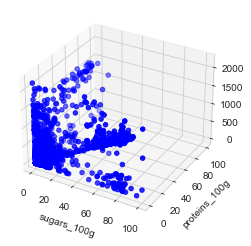

In [25]:
sbe_reg=sbe[['sugars_100g','saturated-fat_100g','proteins_100g','sodium_100g','fiber_100g','energy_100g']]
X=sbe_reg['sugars_100g'].values
Y=sbe_reg['proteins_100g'].values
Z=sbe_reg['energy_100g'].values

fig=plt.figure()
ax=fig.add_subplot(projection='3d').scatter(X,Y,Z,color='b')
plt.xlabel('sugars_100g') 
plt.ylabel('proteins_100g')

plt.show()


On constate que la disposition des points ne permet pas d'obtenir l'energie par une regression lineaire avec le sucre et les proteines puique les points ne sont pas dans un plan. On doit donc utiliser au moins trois variables explicatives pour une regression lineaire.  
Une autre possibilite que la regression est d'utiliser la valeur moyenne des "voisins".
On va utiliser une imputation des valeurs manquantes de l'energie par la moyenne des deux plus proches voisins

In [26]:
import statsmodels.api as sm
X=sbe_reg[['sugars_100g','saturated-fat_100g','proteins_100g','sodium_100g','fiber_100g']]
X=sm.add_constant(X)
reg=sm.OLS(sbe_reg['energy_100g'],X)
res=reg.fit()
coeffs=res.params
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            energy_100g   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     8654.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:05:06   Log-Likelihood:                -92304.
No. Observations:               14148   AIC:                         1.846e+05
Df Residuals:                   14142   BIC:                         1.847e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 49.2356      1.734     28.388      0.000      45.836      52.635
sugars_100g           15.4449      0.077    200.893      0.000      15.294      15.596
saturated-fat_100g    16.3732      1.130     14.485      0.000      14.158      18.589
proteins_100g         16.2235      0.313     51.836      0.000      15.610      16.837
sodium_100g           -4.5721      1.905     -2.401      0.016      -8.305      -0.839
fiber_100g            10.9363      1.272      8.601      0.000       8.444      13.429
==============================================================================
Omnibus:                     8090.582   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           957950.138
Skew:                           1.794   Prob(JB):                         0.00
Kurtosis:                      43.152   Cond. No.                         30.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
from sklearn.impute import KNNImputer


In [28]:
for k in range(10):
    
    subset=select_boisson.sample(200)
    X_reg=subset[['sugars_100g','saturated-fat_100g','proteins_100g','sodium_100g','fiber_100g']]
    X_reg=sm.add_constant(X_reg)
    Y_reg=res.predict(X_reg)
    subset['err_reg']=(Y_reg-subset['energy_100g'])**2
       
    test=select_boisson.copy()
    l=subset['code'].values
    test.loc[test['code'].isin(l),'energy_100g']=np.nan

    kni=KNNImputer(n_neighbors=2)
    z=kni.fit_transform(test[['sugars_100g','saturated-fat_100g','proteins_100g','sodium_100g','fiber_100g','energy_100g']])
    test['energy_100g']=z[:,-1]

    Y_kni=test[test['code'].isin(l)]['energy_100g']
    subset['err_kni']=(Y_kni-subset['energy_100g'])**2
    
    
    print("sample {} % d'erreurs reg > a kni = {}".format(k,(subset['err_reg']>subset['err_kni']).sum()*100/200))
    

sample 0 % d'erreurs reg > a kni = 71.0
sample 1 % d'erreurs reg > a kni = 75.5
sample 2 % d'erreurs reg > a kni = 77.0
sample 3 % d'erreurs reg > a kni = 77.0
sample 4 % d'erreurs reg > a kni = 73.0
sample 5 % d'erreurs reg > a kni = 80.0
sample 6 % d'erreurs reg > a kni = 74.5
sample 7 % d'erreurs reg > a kni = 78.0
sample 8 % d'erreurs reg > a kni = 81.0
sample 9 % d'erreurs reg > a kni = 77.0


Il semble donc preferable d'utiliser KNNImputer

In [29]:
temp=boissons[boissons['etiquette'].isin(['fruit juices','alcoholic beverages','artificially sweetened beverages',
                                                      'fruit nectars','boissons','sirops','sodas '])].copy()

nrj=temp[['sugars_100g','saturated-fat_100g','proteins_100g','sodium_100g','fiber_100g','energy_100g']]

impute=KNNImputer(n_neighbors=2)
nrj_fill=impute.fit_transform(nrj)
temp['energy_100g']=nrj_fill[:,-1]
boissons.loc[boissons['etiquette'].isin(['fruit juices','alcoholic beverages','artificially sweetened beverages','boissons',
                                                      'fruit nectars','sirops','sodas ']),'energy_100g']=temp['energy_100g']
# toutes les valeurs manquantes remplacables ont ete traitees donc on peut supprimer les doublons eventuels sur les codes
boissons.drop_duplicates(subset=['code'],inplace=True)
boissons[main_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41293 entries, 57 to 788902
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   code                         41293 non-null  object 
 1   energy_100g                  37827 non-null  float64
 2   sugars_100g                  37862 non-null  float64
 3   saturated-fat_100g           37879 non-null  float64
 4   fiber_100g                   32378 non-null  float64
 5   proteins_100g                37901 non-null  float64
 6   sodium_100g                  37481 non-null  float64
 7   fruits-vegetables-nuts_100g  27264 non-null  float64
 8   alcohol_100g                 4814 non-null   float64
 9   pnns_groups_2                41293 non-null  object 
 10  categorie                    41293 non-null  object 
 11  nutrition-score-fr_100g      19686 non-null  float64
 12  nutriscore_grade             19686 non-null  object 
dtypes: float64(9),

In [30]:
l=['fruit juices','alcoholic beverages','artificially sweetened beverages','fruit nectars','boissons','sirops','sodas ']
not_score=boissons[((boissons['nutrition-score-fr_100g'].isna())&(boissons['etiquette'].isin(l)))][['code','energy_100g',
                                                                                                    'sugars_100g',
                                                                                           'saturated-fat_100g','fiber_100g',
                                                          'proteins_100g','sodium_100g', 'fruits-vegetables-nuts_100g',
                                                          'etiquette','nutrition-score-fr_100g','nutriscore_grade']]


mask=not_score[['energy_100g','sugars_100g','saturated-fat_100g','fiber_100g','proteins_100g','sodium_100g',
               'fruits-vegetables-nuts_100g' ]].isnull().sum(axis=1)

print('{} produits ont un nutriscore calculable'.format(len(not_score[mask==0])))


15450 produits ont un nutriscore calculable


In [31]:
import nutriscore_grade as nsg

In [32]:
list_codes=not_score[mask==0]['code'].values
for code in list_codes :
    boissons.loc[boissons['code']==code,'nutrition-score-fr_100g']=nsg.nscore(boissons,code)
    boissons.loc[boissons['code']==code,'nutriscore_grade']=nsg.ngrade(boissons,code)


Etude des nutriscore suivant les marques. L'etude n'a ete faite que pour les jus de fruits a titre d'exemple, il suffit de generaliser le processus aux autres etiquettes.

In [33]:
from collections import Counter
def mot_commun(labels, sep=","):
    mots=[]
    for lab in labels:
        mots+=str(lab).split(sep)
    count=Counter(mots)
    print([mot for mot in count.most_common(50)])



mot_commun(boissons[boissons['brands'].notna()]['brands'],sep=',')

[('u', 955), ('carrefour', 690), ('auchan', 667), ('marque repere', 568), ('lipton', 547), ('coca-cola', 424), ('casino', 407), ('tropicana', 345), ('leader price', 329), ('cora', 303), ('teisseire', 234), ('paquito', 215), ('schweppes', 209), ('monoprix', 204), ('solevita', 203), ('nestle', 182), ('jafaden', 180), ('belle france', 175), ('monin', 172), ('nescafe', 169), ('innocent', 161), ('joker', 151), ('andros', 148), ('fanta', 137), (' u', 135), ('yoplait', 132), ('vitamont', 129), ('marks & spencer', 128), ('netto', 122), ('kusmi tea', 120), ('oasis', 119), ('pressade', 119), ('granini', 119), ('la vie claire', 118), ('nespresso', 115), ('gerard bertrand', 112), ('pepsi', 110), ('volvic', 110), ('twinings', 107), ('lidl', 107), ('u bio', 107), ('carte noire', 107), ('bio village', 104), (' marque repere', 102), ('don simon', 99), ('arizona', 97), ('franprix', 97), ('coca cola', 95), ('sodastream', 93), ('danone', 91)]


In [34]:
list_marq=['tropicana','paquito','solevita','joker','granini']
marks_jus=boissons[((boissons['brands'].isin(list_marq))&(boissons['etiquette']=='fruit juices'))].copy()
X='nutriscore_grade'
Y='brands'
marq_grade=marks_jus[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name='total')
marq_grade

brands,granini,joker,paquito,solevita,tropicana,total
nutriscore_grade,,,,,,
b,2,14,2,8,10,36
c,26,90,58,73,217,464
d,4,3,23,19,33,82
e,3,2,3,3,4,15
total,35,109,86,103,264,597


In [35]:
mg=marks_jus[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
mg_pct=mg/mg.sum(axis=0)
mg_pct

brands,granini,joker,paquito,solevita,tropicana
nutriscore_grade,,,,,
b,0.057143,0.128440,0.023256,0.077670,0.037879
c,0.742857,0.825688,0.674419,0.708738,0.821970
d,0.114286,0.027523,0.267442,0.184466,0.125000
e,0.085714,0.018349,0.034884,0.029126,0.015152


D'apres ce tableau il est preferable de commencer par regarder les jus de fruits de la marque joker lorsque l'on a un probleme de sante. Ceci dit cette remarque ne tient pas compte de la qualité du gout des jus ni du prix.

### Utilisation pour l'appli

Dans l'ideal, l'appli fonctionnerait de la maniere suivante :
l'utilisateur rentre le probleme de sante qui le concerne.
Il choisit un produit et rentre son codebarre. Il choisit alors s'il veut une reponse visuelle ou orale (utile pour les mal- voyants). Il reçoit un message pour lui dire soit il vaut mieux changer de produits soit le produit est OK pour lui. Lorsqu'il doit changer de produit on lui propose une gamme de produits plus adaptes a son probleme de sante.

Le travail n'a ete fait que pour certaines boissons. Le travail sur les marques pourraient etre interessant en particulier pour conseiller de choisir un produit plutot d'une marque donnee car souvent meilleure pour la sante. Sauf que je ne connais pas la juridiction concernant l'utilisation des marques dans une appli. 

Ci-dessous : exemples de fonctions a utiliser pour delivrer le message et la proposition d'autres produits du meme style.

In [36]:
def pref(barcode,cat,nutri,data=boissons):
    '''Return une liste de produit dont la quantite de nutri est inferieur au premier quantile,triee suivant la quantite
    du nutri puis du nutrigrade
    Args : barcode (string) le code-barres du produit de reference, cat (string) type du produit de reference,
           nutri (string) le nutriment concerne par la pathologie, data base de donnees concernee
    Return : base de donnees des meilleurs produits du meme type triee par quantite de nutri et nutriscore '''
    
    #creation d'une liste de mots adaptee a la categorie par exemple pour les jus de fruits
    mots_fruits=['orange','pomme','abricots','ananas','pamplemousse','mangue','kiwi']
    q1=data[data['etiquette']==cat][nutri].quantile(0.25)
    codes=data[((data['etiquette']==cat)&(data[nutri]<=q1))]['code'].values
    t=data[data['code'].isin(codes)]['product_name'].unique()
    k=0
    while k<len(mots_fruits) :
        if mots_fruits[k] in data[data['code']==barcode]['product_name'].values[0] :
            mot=mots_fruits[k]
            break
        else: k+=1
    if k<len(mots_fruits) :
        l=[z for z in t if mot in z]
        d=data[((data['code'].isin(codes))&(data['product_name'].isin(l))&(data['nutriscore_grade'].notna()))][['code',
                                                                               'product_name',nutri,'nutriscore_grade']].copy()
        
    else :
        d=data[((data['code'].isin(codes))&(data['nutriscore_grade'].notna()))][['code','product_name',
                                                                                 nutri,'nutriscore_grade']].copy()
        
    return d.sort_values(by=([nutri,'nutriscore_grade']))
                   
def proposition(barcode,patho,cat,data=boissons):
    '''Return un appel a la fonction pref avec choix du nutri suivant la pathologie
    Args : barcode (string) le code-barres du produit, patho (string) la pathologie, cat (string) le type du produit
           data : base de donnees concernee par le produit
    Return : appel de la fonction pref'''
    
    if patho=='diabete':
        return pref(barcode,cat,'sugars_100g',data=boissons)
    elif patho=='cholesterol':
        return pref(barcode,cat,'saturated-fat_100g',data=boissons) 
    elif patho=='cardio':
        return pref(barcode,cat,'sodium_100g',data=boissons)
    
def choix_message(barcode,patho,nutri,cat,data=boissons):
    '''Return le message adequate suivant la pathologie et le produit
    Args : barcode (string) le code-barres du produit, patho (string) la pathologie, 
           nutri(string) le nutriment concerne par la pathologie cat (string) le type du produit
           data : base de donnees concernee par le produit
    Reurn : Impression du message avec appel a le fonction proposition'''
    
    test=data[data['code']==barcode][nutri]
    if test.isna().any() :
        return None
    x=test.values[0]
    moy=data[data['etiquette']==cat][nutri].mean()
    q1=data[data['etiquette']==cat][nutri].quantile(0.25)
    q3=data[data['etiquette']==cat][nutri].quantile(0.75)
    if nutri=='sugars_100g':
        mot='sucre'
    elif nutri=='saturated-fat_100g':
        mot='AGS'
    else: mot='sodium'
        
    mess='Produits avec moins de {}: \n '
    if x>=q3 :
        print('Alerte, produit a eviter : {} de {} pour 100ml'.format(x,mot))
        print(mess.format(mot),proposition(barcode,patho,cat,data=boissons))
    elif (x>moy and x<q3):
        print('Attention {} de {} pour 100ml, plus eleve que la moyenne des {}'.format(x,mot,cat))
        print(mess.format(mot),proposition(barcode,patho,cat,data=boissons))
    elif (x>q1 and x<=moy):
        print ('{} de {} pour 100ml'.format(x,mot))
        print(mess.format(mot),proposition(barcode,patho,cat,data=boissons))
    else :
        print ('{} de {} pour 100ml, ce qui est bien pour les {}'.format(x,mot,cat))

def alerte(barcode,patho,data=boissons):
    etiq=data[data['code']==barcode]['etiquette'].values[0]
    if patho=='diabete':
        nutri='sugars_100g'
    elif patho =='cholesterol':
        nutri='saturated-fat_100g'
    elif patho =='cardio':
        nutri='sodium_100g'
    return choix_message(barcode,patho,nutri,etiq,data=boissons)

        

In [37]:
barcode='000000001576'
alerte(barcode,'diabete',boissons)

0.01 de sucre pour 100ml, ce qui est bien pour les fruit juices


In [38]:
barcode='3250391738373'
alerte(barcode,'cardio',boissons)


Alerte, produit a eviter : 4.0 de sodium pour 100ml
Produits avec moins de sodium: 
                   code                                       product_name  \
386122  3502110004765                    essentiels fibres ananas mangue   
442002  3608580902454                                     ananas passion   
467291  3700656402964                                 pomme peche ananas   
498719  3760099400125  l'etincelle - carotte, ananas, curcuma, citron...   
537816  3770003279471                                  jus baobab ananas   
...               ...                                                ...   
756671  8698720868929                                        juss ananas   
768700  8718226323101                                       jus d'ananas   
780253  9001400103170                                        jus dananas   
377169  3473360900711                                 jus d'ananas 100 %   
563402  4015533025532                                 raison ananas coco   

 